Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

1: Total tims is  60.59 s
2: Total numb steps is  64


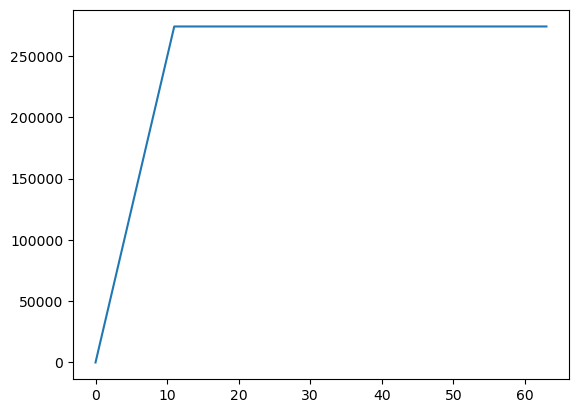

In [1]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    functionspace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 2200
v_vehicle = 160
c_acc = 1

# calling local functions to get all parameters
(
    dt,
    P,
    g,
    num_steps,
    h,
    radiation,
    v_angular,
    Ti,
    Tm,
    S_rub_circle,
    t,
    rho,
    c,
    k,
    t_brake,
    S_total,
) = vehicle_initial(angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)
plt.plot(P)

In [2]:
print(k)
print(h)

0.048
7.75e-05


## 2: Mesh

In [3]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [4]:
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition

x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [5]:
print(dt[0])

0.39741147067910887


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = ufl.TrialFunction(V)
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)


F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u_n), grad(v)) * dx
    + h * inner(u_n, v) * ds(200)
    + radiation * inner(u_n**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u_n, v) * ds(10 * i)  
          - radiation * inner( (u_n**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)



2024-05-23 10:15:15.138 (   4.451s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:15.299 (   4.612s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:15.359 (   4.671s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00987548 (tol = 1e-10) r (rel) = 1.58725e-06(tol = 1e-06)
2024-05-23 10:15:15.380 (   4.692s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:15.423 (   4.736s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.75097e-08 (tol = 1e-10) r (rel) = 7.63603e-12(tol = 1e-06)
2024-05-23 10:15:15.423 (   4.736s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.



This part is (u_n - Tm) together, while backward euler separate.
F = (
      (rho * c) / dt[i] * inner(u, v) * dx
    + h * (u_n - Tm) * v * ds(200)
    + radiation * (u_n**4 - Tm**4) * v * ds(200)  
    + k * inner(grad(u_n), grad(v)) * dx
    - inner(f, v) * dx
    - inner(u_n, v) * dx
    )

    ## inner is for vector or tensor, v is first order lagrange element, so it is a saclar field.

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
        F += (
            + inner(g[i], v) * ds(10* j) 
            - h* (u_n - Tm)*v* ds(10* j) 
            - radiation*(u_n**4 -Tm**4) *v*ds(10* j)
        )
        

In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    ####### new
    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u_n), grad(v)) * dx
        + h * inner(u_n, v) * ds(200)
        + radiation * inner(u_n**4, v) * ds(200)
        - ( 
           inner(f, v) * dx
           + (rho * c) / dt[i] * inner(u_n, v) * dx
           + h * Tm * v * ds(200)
           + radiation * (Tm**4) * v * ds(200)      
          ) 
        )

    for j in list(range(1, 19)):
        F += ( 
              + inner(g[i], v) * ds(10 * j) 
              - h * inner( u_n, v) * ds(10 * j)  
              - radiation * inner( (u_n**4 - Tm**4), v) * ds(10 * j) 
             )
       

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 2200 degree. 2: Current time is 0.4 s. 3: Completion is 0.8 %. 

2024-05-23 10:15:18.617 (   7.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:18.617 (   7.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:18.617 (   7.930s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:18.618 (   7.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:18.620 (   7.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:18.620 (   7.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:18.621 (   7.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:18.622 (   7.934s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.8 %. 

2024-05-23 10:15:19.521 (   8.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:15:19.521 (   8.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:15:19.536 (   8.849s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:15:19.569 (   8.882s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:19.654 (   8.967s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:19.689 (   9.002s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 2.13275e-05 (tol = 1e-10) r (rel) = 4.80399e-06(tol = 1e-06)
2024-05-23 10:15:19.697 (   9.021s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:19.726 (

1: Rotation has applied for 4400 degree. 2: Current time is 0.8 s. 3: Completion is 1.6 %. 

2024-05-23 10:15:20.103 (   9.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:20.105 (   9.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:20.105 (   9.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:20.105 (   9.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:20.105 (   9.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:20.105 (   9.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:20.105 (   9.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:20.105 (   9.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 1.6 %. 

2024-05-23 10:15:30.414 (  19.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:15:30.414 (  19.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:15:30.431 (  19.743s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:15:30.460 (  19.773s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:30.556 (  19.869s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:30.596 (  19.909s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000908369 (tol = 1e-10) r (rel) = 5.19517e-06(tol = 1e-06)
2024-05-23 10:15:30.616 (  19.929s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 6600 degree. 2: Current time is 1.2 s. 3: Completion is 2.5 %. 

2024-05-23 10:15:30.660 (  19.973s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 5.83009e-09 (tol = 1e-10) r (rel) = 3.33436e-11(tol = 1e-06)
2024-05-23 10:15:30.660 (  19.973s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 10:15:30.661 (  19.973s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:15:30.759 (  20.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:30.760 (  20.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:30.760 (  20.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:30.760 (  20.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 2.5 %. 

2024-05-23 10:15:41.399 (  30.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:15:41.399 (  30.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:15:41.414 (  30.726s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:15:41.442 (  30.754s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:41.523 (  30.837s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:41.542 (  30.862s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00187753 (tol = 1e-10) r (rel) = 5.07469e-06(tol = 1e-06)
2024-05-23 10:15:41.570 (  30.883s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:41.589 ( 

1: Rotation has applied for 8800 degree. 2: Current time is 1.6 s. 3: Completion is 3.3 %. 

2024-05-23 10:15:41.699 (  31.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:41.699 (  31.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:41.700 (  31.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:41.700 (  31.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:41.700 (  31.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:41.700 (  31.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:41.700 (  31.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:41.701 (  31.013s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 3.3 %. 

2024-05-23 10:15:53.046 (  42.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:15:53.046 (  42.359s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:15:53.061 (  42.373s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:15:53.092 (  42.404s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:53.190 (  42.503s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:53.212 (  42.524s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0031348 (tol = 1e-10) r (rel) = 5.2491e-06(tol = 1e-06)
2024-05-23 10:15:53.225 (  42.538s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:15:53.249 (  4

1: Rotation has applied for 11000 degree. 2: Current time is 2.0 s. 3: Completion is 4.1 %. 

2024-05-23 10:15:53.250 (  42.563s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:15:53.318 (  42.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:53.318 (  42.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:53.318 (  42.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:53.320 (  42.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:53.321 (  42.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:15:53.321 (  42.633s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:15:53.321 (  42.633s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 4.1 %. 

2024-05-23 10:16:03.269 (  52.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:03.269 (  52.581s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:03.284 (  52.596s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:16:03.329 (  52.642s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:03.452 (  52.765s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:03.478 (  52.790s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00425904 (tol = 1e-10) r (rel) = 4.62833e-06(tol = 1e-06)


1: Rotation has applied for 13200 degree. 2: Current time is 2.4 s. 3: Completion is 5.0 %. 

2024-05-23 10:16:03.500 (  52.813s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:03.567 (  52.879s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.75587e-08 (tol = 1e-10) r (rel) = 2.99482e-11(tol = 1e-06)
2024-05-23 10:16:03.567 (  52.880s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 10:16:03.567 (  52.880s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:16:03.654 (  52.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:03.655 (  52.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:03.655 (  52.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 5.0 %. 

2024-05-23 10:16:13.270 (  62.585s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:13.273 (  62.586s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:13.288 (  62.600s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:16:13.318 (  62.631s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:13.426 (  62.738s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:13.445 (  62.758s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.00660767 (tol = 1e-10) r (rel) = 3.38387e-06(tol = 1e-06)
2024-05-23 10:16:13.465 (  62.777s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:13.488 ( 

1: Rotation has applied for 15400 degree. 2: Current time is 2.9 s. 3: Completion is 5.8 %. 

2024-05-23 10:16:13.595 (  62.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:13.596 (  62.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:13.596 (  62.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:13.596 (  62.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:13.596 (  62.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:13.596 (  62.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:13.596 (  62.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:13.597 (  62.909s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 5.8 %. 

2024-05-23 10:16:23.254 (  72.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:23.256 (  72.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:23.270 (  72.584s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:16:23.296 (  72.609s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 17600 degree. 2: Current time is 3.3 s. 3: Completion is 6.7 %. 

2024-05-23 10:16:23.513 (  72.825s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:23.544 (  72.857s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0127892 (tol = 1e-10) r (rel) = 2.07657e-06(tol = 1e-06)
2024-05-23 10:16:23.579 (  72.892s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:23.609 (  72.922s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.3117e-08 (tol = 1e-10) r (rel) = 1.1872e-11(tol = 1e-06)
2024-05-23 10:16:23.609 (  72.922s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 10:16:23.610 (  72.922s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:16:23.694 (  73.006s) [main            ]topologycomputa

1: Completion is 6.7 %. 

2024-05-23 10:16:32.860 (  82.173s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:32.861 (  82.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:32.876 (  82.188s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 19800 degree. 2: Current time is 3.7 s. 3: Completion is 7.6 %. 

2024-05-23 10:16:32.909 (  82.222s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:33.150 (  82.463s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:33.172 (  82.485s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0409862 (tol = 1e-10) r (rel) = 1.45274e-06(tol = 1e-06)
2024-05-23 10:16:33.192 (  82.504s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:33.208 (  82.521s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.37674e-07 (tol = 1e-10) r (rel) = 8.42429e-12(tol = 1e-06)
2024-05-23 10:16:33.210 (  82.527s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 10:16:33.214 (  82.527s) [main            ]      xdmf_funct

1: Completion is 7.6 %. 

2024-05-23 10:16:42.441 (  91.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:42.441 (  91.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:42.458 (  91.771s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:16:42.489 (  91.802s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:42.569 (  91.881s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:42.590 (  91.904s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.275858 (tol = 1e-10) r (rel) = 1.36044e-06(tol = 1e-06)
2024-05-23 10:16:42.609 (  91.922s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:42.631 (  9

1: Rotation has applied for 22000 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-05-23 10:16:42.708 (  92.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:42.708 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:42.708 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:42.708 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:42.708 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:42.709 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:42.709 (  92.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:42.709 (  92.022s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 8.4 %. 

2024-05-23 10:16:51.880 ( 101.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:16:51.880 ( 101.193s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:16:51.894 ( 101.207s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:16:51.926 ( 101.238s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:52.013 ( 101.326s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:52.035 ( 101.347s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 2.77449 (tol = 1e-10) r (rel) = 1.42738e-06(tol = 1e-06)
2024-05-23 10:16:52.057 ( 101.369s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:16:52.074 ( 101

1: Rotation has applied for 24200 degree. 2: Current time is 4.6 s. 3: Completion is 9.3 %. 

2024-05-23 10:16:52.166 ( 101.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:52.166 ( 101.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:52.166 ( 101.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:52.167 ( 101.479s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:52.167 ( 101.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:52.167 ( 101.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:16:52.167 ( 101.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:16:52.167 ( 101.480s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 9.3 %. 

2024-05-23 10:17:01.377 ( 110.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:01.377 ( 110.690s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:01.390 ( 110.703s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:01.421 ( 110.734s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:01.497 ( 110.810s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:01.522 ( 110.835s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 21854.4 (tol = 1e-10) r (rel) = 4.49116e-06(tol = 1e-06)
2024-05-23 10:17:01.543 ( 110.856s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:01.558 ( 110

1: Rotation has applied for 26400 degree. 2: Current time is 5.0 s. 3: Completion is 10.2 %. 

2024-05-23 10:17:01.639 ( 110.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:01.640 ( 110.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:01.640 ( 110.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:01.640 ( 110.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:01.641 ( 110.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:01.641 ( 110.953s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:01.641 ( 110.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:01.641 ( 110.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 10.2 %. 

2024-05-23 10:17:11.384 ( 120.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:11.385 ( 120.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:11.406 ( 120.719s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:11.444 ( 120.757s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:11.493 ( 120.834s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:11.542 ( 120.854s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 2.95121e+21 (tol = 1e-10) r (rel) = 4.6039e-06(tol = 1e-06)
2024-05-23 10:17:11.564 ( 120.877s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:11.593 ( 

1: Rotation has applied for 28600 degree. 2: Current time is 5.4 s. 3: Completion is 11.1 %. 

2024-05-23 10:17:11.674 ( 120.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:11.674 ( 120.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:11.675 ( 120.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:11.675 ( 120.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:11.675 ( 120.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:11.675 ( 120.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:11.676 ( 120.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:11.676 ( 120.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 11.1 %. 

2024-05-23 10:17:22.610 ( 131.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:22.610 ( 131.923s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:22.629 ( 131.942s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:22.657 ( 131.970s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:22.771 ( 132.083s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:22.800 ( 132.113s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 1.87754e+90 (tol = 1e-10) r (rel) = 4.31497e-06(tol = 1e-06)
2024-05-23 10:17:22.823 ( 132.135s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 30800 degree. 2: Current time is 5.9 s. 3: Completion is 12.0 %. 

2024-05-23 10:17:22.846 ( 132.159s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.18358e+85 (tol = 1e-10) r (rel) = 2.7201e-11(tol = 1e-06)
2024-05-23 10:17:22.846 ( 132.159s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-23 10:17:22.846 ( 132.159s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:17:22.919 ( 132.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:22.920 ( 132.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:22.920 ( 132.232s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:22.920 ( 132.233s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05

1: Completion is 12.0 %. 

2024-05-23 10:17:33.371 ( 142.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:33.371 ( 142.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:33.386 ( 142.699s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:33.420 ( 142.732s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:33.506 ( 142.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 33000 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-05-23 10:17:33.661 ( 142.974s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:17:33.661 ( 142.974s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:17:33.661 ( 142.974s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:17:33.773 ( 143.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:33.774 ( 143.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:33.774 ( 143.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17:33.774 ( 143.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:33.774 

1: Completion is 12.9 %. 

2024-05-23 10:17:44.818 ( 154.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:44.818 ( 154.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:44.834 ( 154.147s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:44.866 ( 154.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 35200 degree. 2: Current time is 6.8 s. 3: Completion is 13.9 %. 

2024-05-23 10:17:45.041 ( 154.354s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:45.088 ( 154.401s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:17:45.088 ( 154.401s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:17:45.089 ( 154.401s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:17:45.208 ( 154.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:45.208 ( 154.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:45.208 ( 154.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17

1: Completion is 13.9 %. 

2024-05-23 10:17:55.971 ( 165.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:17:55.971 ( 165.284s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:17:55.991 ( 165.304s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:17:56.025 ( 165.338s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 37400 degree. 2: Current time is 7.3 s. 3: Completion is 14.8 %. 

2024-05-23 10:17:56.138 ( 165.451s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:17:56.265 ( 165.577s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:17:56.265 ( 165.577s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:17:56.265 ( 165.578s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:17:56.358 ( 165.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:56.360 ( 165.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:17:56.360 ( 165.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:17

1: Completion is 14.8 %. 

2024-05-23 10:18:07.776 ( 177.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:18:07.776 ( 177.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:18:07.802 ( 177.114s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:18:07.842 ( 177.155s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 39600 degree. 2: Current time is 7.7 s. 3: Completion is 15.8 %. 

2024-05-23 10:18:08.097 ( 177.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:08.306 ( 177.618s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:18:08.306 ( 177.618s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:18:08.307 ( 177.620s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:18:08.418 ( 177.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:08.418 ( 177.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:08.418 ( 177.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:18

1: Completion is 15.8 %. 

2024-05-23 10:18:21.280 ( 190.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:18:21.280 ( 190.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:18:21.295 ( 190.608s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:18:21.331 ( 190.644s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 41800 degree. 2: Current time is 8.2 s. 3: Completion is 16.7 %. 

2024-05-23 10:18:21.548 ( 190.860s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:21.561 ( 190.873s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:18:21.561 ( 190.874s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:18:21.561 ( 190.874s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:18:21.629 ( 190.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:21.629 ( 190.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:21.629 ( 190.942s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:18

1: Completion is 16.7 %. 

2024-05-23 10:18:32.085 ( 201.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:18:32.085 ( 201.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:18:32.101 ( 201.413s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 44000 degree. 2: Current time is 8.7 s. 3: Completion is 17.7 %. 

2024-05-23 10:18:32.132 ( 201.445s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:32.403 ( 201.716s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:32.474 ( 201.787s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:18:32.475 ( 201.787s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:18:32.475 ( 201.787s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:18:32.561 ( 201.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:32.561 ( 201.874s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-

1: Completion is 17.7 %. 

2024-05-23 10:18:42.508 ( 211.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:18:42.508 ( 211.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:18:42.531 ( 211.844s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:18:42.580 ( 211.893s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:42.681 ( 211.994s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 46200 degree. 2: Current time is 9.2 s. 3: Completion is 18.7 %. 

2024-05-23 10:18:42.760 ( 212.073s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:18:42.760 ( 212.073s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:18:42.761 ( 212.073s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:18:42.862 ( 212.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:42.874 ( 212.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:42.875 ( 212.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:18:42.875 ( 212.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:42.876 

1: Completion is 18.7 %. 

2024-05-23 10:18:53.174 ( 222.487s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:18:53.175 ( 222.488s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:18:53.190 ( 222.503s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:18:53.210 ( 222.525s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:18:53.382 ( 222.695s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 48400 degree. 2: Current time is 9.6 s. 3: Completion is 19.7 %. 

2024-05-23 10:18:53.438 ( 222.751s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:18:53.439 ( 222.751s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:18:53.439 ( 222.751s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:18:53.522 ( 222.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:53.523 ( 222.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:53.523 ( 222.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:18:53.523 ( 222.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:18:53.523 

1: Rotation has applied for 50600 degree. 2: Current time is 10.1 s. 3: Completion is 20.7 %. 

2024-05-23 10:19:03.106 ( 232.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:03.109 ( 232.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:03.125 ( 232.438s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:03.152 ( 232.465s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:03.225 ( 232.538s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:03.226 ( 232.539s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:03.241 ( 232.554s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:

1: Completion is 20.7 %. 

2024-05-23 10:19:13.214 ( 242.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:13.218 ( 242.531s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:13.226 ( 242.545s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:13.258 ( 242.571s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:13.378 ( 242.703s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 52800 degree. 2: Current time is 10.6 s. 3: Completion is 21.7 %. 

2024-05-23 10:19:13.431 ( 242.743s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:13.431 ( 242.743s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:13.431 ( 242.744s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:19:13.521 ( 242.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:13.521 ( 242.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:13.521 ( 242.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19:13.521 ( 242.834s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:13.522 

1: Completion is 21.7 %. 

2024-05-23 10:19:23.159 ( 252.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:23.159 ( 252.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:23.171 ( 252.485s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:23.202 ( 252.515s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:23.309 ( 252.622s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:23.364 ( 252.677s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:23.364 ( 252.677s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:

1: Rotation has applied for 55000 degree. 2: Current time is 11.2 s. 3: Completion is 22.8 %. 

2024-05-23 10:19:23.447 ( 252.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:23.447 ( 252.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:23.447 ( 252.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19:23.448 ( 252.760s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:23.448 ( 252.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:23.448 ( 252.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19:23.448 ( 252.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:23.449 ( 252.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 57200 degree. 2: Current time is 11.7 s. 3: Completion is 23.8 %. 

2024-05-23 10:19:32.585 ( 261.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:32.585 ( 261.898s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:32.600 ( 261.913s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:32.634 ( 261.947s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:32.693 ( 262.006s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:32.710 ( 262.022s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:32.710 ( 262.023s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:

1: Completion is 23.8 %. 

2024-05-23 10:19:42.181 ( 271.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:42.182 ( 271.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:42.197 ( 271.509s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:42.221 ( 271.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:42.310 ( 271.625s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:42.325 ( 271.637s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:42.325 ( 271.638s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:

1: Rotation has applied for 59400 degree. 2: Current time is 12.2 s. 3: Completion is 24.9 %. 

2024-05-23 10:19:42.412 ( 271.725s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:42.413 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:42.413 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19:42.413 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:42.413 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:42.413 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19:42.414 ( 271.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:42.414 ( 271.727s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 24.9 %. 

2024-05-23 10:19:52.372 ( 281.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:19:52.372 ( 281.684s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:19:52.387 ( 281.700s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:19:52.421 ( 281.733s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 61600 degree. 2: Current time is 12.7 s. 3: Completion is 26.0 %. 

2024-05-23 10:19:52.510 ( 281.823s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:19:52.524 ( 281.837s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:19:52.525 ( 281.837s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:19:52.525 ( 281.838s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:19:52.608 ( 281.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:52.608 ( 281.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:19:52.608 ( 281.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:19

1: Completion is 26.0 %. 

2024-05-23 10:20:02.130 ( 291.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:02.132 ( 291.445s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:02.147 ( 291.459s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:02.177 ( 291.489s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:02.264 ( 291.589s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:02.293 ( 291.605s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:02.293 ( 291.605s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:20:

1: Rotation has applied for 63800 degree. 2: Current time is 13.3 s. 3: Completion is 27.1 %. 

2024-05-23 10:20:02.387 ( 291.699s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:02.389 ( 291.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:02.389 ( 291.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:02.389 ( 291.701s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:02.390 ( 291.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:02.390 ( 291.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:02.390 ( 291.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:02.391 ( 291.703s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 27.1 %. 

2024-05-23 10:20:11.924 ( 301.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:11.925 ( 301.237s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:11.940 ( 301.252s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:11.979 ( 301.292s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:12.065 ( 301.378s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:12.066 ( 301.391s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:12.079 ( 301.391s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.


1: Rotation has applied for 66000 degree. 2: Current time is 13.8 s. 3: Completion is 28.2 %. 

2024-05-23 10:20:12.079 ( 301.392s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:20:12.177 ( 301.490s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:12.178 ( 301.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:12.179 ( 301.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:12.179 ( 301.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:12.179 ( 301.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:12.179 ( 301.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:12.179 ( 301.492s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 28.2 %. 

2024-05-23 10:20:22.093 ( 311.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:22.094 ( 311.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:22.108 ( 311.421s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:22.134 ( 311.446s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:22.233 ( 311.546s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:22.252 ( 311.565s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:22.252 ( 311.565s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:20:

1: Rotation has applied for 68200 degree. 2: Current time is 14.4 s. 3: Completion is 29.3 %. 

2024-05-23 10:20:22.344 ( 311.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:22.345 ( 311.658s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:22.346 ( 311.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:22.347 ( 311.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:22.347 ( 311.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:22.347 ( 311.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:22.348 ( 311.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:22.348 ( 311.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 29.3 %. 

2024-05-23 10:20:32.330 ( 321.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:32.330 ( 321.642s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:32.350 ( 321.662s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:32.387 ( 321.699s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:32.453 ( 321.766s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:32.510 ( 321.822s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:32.510 ( 321.822s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:20:

1: Rotation has applied for 70400 degree. 2: Current time is 14.9 s. 3: Completion is 30.4 %. 

2024-05-23 10:20:32.604 ( 321.917s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:32.606 ( 321.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:32.607 ( 321.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:32.607 ( 321.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:32.607 ( 321.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:32.607 ( 321.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:32.607 ( 321.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:32.608 ( 321.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 30.4 %. 

2024-05-23 10:20:42.541 ( 331.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:42.541 ( 331.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:42.554 ( 331.867s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:42.593 ( 331.905s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:42.662 ( 331.975s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:42.663 ( 331.978s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:42.677 ( 331.990s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:20:

1: Rotation has applied for 72600 degree. 2: Current time is 15.5 s. 3: Completion is 31.6 %. 

2024-05-23 10:20:42.775 ( 332.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:42.776 ( 332.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:42.776 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:42.776 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:42.776 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:42.776 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20:42.777 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:42.777 ( 332.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 31.6 %. 

2024-05-23 10:20:52.308 ( 341.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:20:52.308 ( 341.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:20:52.318 ( 341.631s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:20:52.350 ( 341.663s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 74800 degree. 2: Current time is 16.1 s. 3: Completion is 32.8 %. 

2024-05-23 10:20:52.704 ( 342.017s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:20:52.722 ( 342.034s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:20:52.722 ( 342.034s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:20:52.722 ( 342.035s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:20:52.805 ( 342.118s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:52.806 ( 342.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:20:52.806 ( 342.119s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:20

1: Completion is 32.8 %. 

2024-05-23 10:21:02.245 ( 351.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:02.245 ( 351.558s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:02.261 ( 351.574s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:02.310 ( 351.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:02.398 ( 351.711s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:02.453 ( 351.766s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:02.453 ( 351.766s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:

1: Rotation has applied for 77000 degree. 2: Current time is 16.7 s. 3: Completion is 34.0 %. 

2024-05-23 10:21:02.546 ( 351.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:02.547 ( 351.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:02.548 ( 351.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 34.0 %. 

2024-05-23 10:21:12.409 ( 361.722s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:12.410 ( 361.723s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:12.422 ( 361.738s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:12.462 ( 361.775s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 79200 degree. 2: Current time is 17.3 s. 3: Completion is 35.2 %. 

2024-05-23 10:21:12.642 ( 361.962s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:12.666 ( 361.979s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:12.666 ( 361.979s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:12.667 ( 361.979s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:21:12.775 ( 362.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:12.776 ( 362.088s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:12.776 ( 362.089s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21

1: Completion is 35.2 %. 

2024-05-23 10:21:22.429 ( 371.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:22.430 ( 371.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:22.445 ( 371.758s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:22.470 ( 371.783s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 81400 degree. 2: Current time is 17.9 s. 3: Completion is 36.5 %. 

2024-05-23 10:21:22.661 ( 371.974s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:22.682 ( 371.994s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:22.682 ( 371.994s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:22.682 ( 371.994s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:21:22.752 ( 372.064s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:22.752 ( 372.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:22.752 ( 372.065s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21

1: Completion is 36.5 %. 

2024-05-23 10:21:32.244 ( 381.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:32.244 ( 381.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:32.259 ( 381.572s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:32.289 ( 381.602s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:32.366 ( 381.679s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:32.383 ( 381.695s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:32.383 ( 381.696s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:

1: Rotation has applied for 83600 degree. 2: Current time is 18.5 s. 3: Completion is 37.8 %. 

2024-05-23 10:21:32.484 ( 381.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:32.484 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:32.484 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:32.484 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:32.485 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:32.485 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:32.485 ( 381.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:32.485 ( 381.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 37.8 %. 

2024-05-23 10:21:42.290 ( 391.603s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:42.294 ( 391.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:42.308 ( 391.621s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:42.335 ( 391.648s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:42.409 ( 391.722s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:42.425 ( 391.737s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:42.425 ( 391.737s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:

1: Rotation has applied for 85800 degree. 2: Current time is 19.1 s. 3: Completion is 39.1 %. 

2024-05-23 10:21:42.524 ( 391.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:42.525 ( 391.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:42.525 ( 391.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:42.525 ( 391.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:42.526 ( 391.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:42.526 ( 391.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:42.526 ( 391.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:42.527 ( 391.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 39.1 %. 

2024-05-23 10:21:52.271 ( 401.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:21:52.271 ( 401.584s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:21:52.284 ( 401.597s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:21:52.318 ( 401.630s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:21:52.430 ( 401.743s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 88000 degree. 2: Current time is 19.8 s. 3: Completion is 40.4 %. 

2024-05-23 10:21:52.475 ( 401.790s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:21:52.477 ( 401.790s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:21:52.477 ( 401.790s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:21:52.564 ( 401.876s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:52.564 ( 401.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:52.564 ( 401.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:21:52.565 ( 401.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:21:52.565 

1: Completion is 40.4 %. 

2024-05-23 10:22:01.993 ( 411.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:01.994 ( 411.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:02.013 ( 411.326s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:02.041 ( 411.354s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:02.151 ( 411.464s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 90200 degree. 2: Current time is 20.5 s. 3: Completion is 41.8 %. 

2024-05-23 10:22:02.221 ( 411.535s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:02.222 ( 411.535s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:22:02.233 ( 411.546s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:22:02.327 ( 411.639s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:02.327 ( 411.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:02.327 ( 411.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:02.327 ( 411.640s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:02.328 

1: Completion is 41.8 %. 

2024-05-23 10:22:11.655 ( 420.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:11.655 ( 420.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:11.675 ( 420.988s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:11.705 ( 421.017s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:11.809 ( 421.122s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:11.846 ( 421.163s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:11.852 ( 421.165s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:22:

1: Rotation has applied for 92400 degree. 2: Current time is 21.1 s. 3: Completion is 43.1 %. 

2024-05-23 10:22:11.940 ( 421.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:11.941 ( 421.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:11.942 ( 421.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.1 %. 

2024-05-23 10:22:21.020 ( 430.333s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:21.022 ( 430.335s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:21.040 ( 430.353s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:21.093 ( 430.406s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:21.150 ( 430.485s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:21.188 ( 430.500s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:21.188 ( 430.500s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:22:

1: Rotation has applied for 94600 degree. 2: Current time is 21.8 s. 3: Completion is 44.6 %. 

2024-05-23 10:22:21.287 ( 430.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:21.288 ( 430.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:21.288 ( 430.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:21.288 ( 430.601s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:21.289 ( 430.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:21.289 ( 430.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:21.289 ( 430.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:21.290 ( 430.602s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 44.6 %. 

2024-05-23 10:22:30.645 ( 439.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:30.645 ( 439.958s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:30.658 ( 439.971s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:30.689 ( 440.001s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:30.759 ( 440.072s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:30.762 ( 440.088s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:30.776 ( 440.089s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:22:

1: Rotation has applied for 96800 degree. 2: Current time is 22.6 s. 3: Completion is 46.0 %. 

2024-05-23 10:22:30.892 ( 440.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:30.892 ( 440.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:30.892 ( 440.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:30.893 ( 440.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:30.893 ( 440.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:30.893 ( 440.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:30.893 ( 440.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:30.893 ( 440.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 46.0 %. 

2024-05-23 10:22:40.238 ( 449.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:40.238 ( 449.550s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:40.252 ( 449.565s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:40.277 ( 449.589s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:40.364 ( 449.677s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:40.435 ( 449.748s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:40.435 ( 449.748s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:22:

1: Rotation has applied for 99000 degree. 2: Current time is 23.3 s. 3: Completion is 47.5 %. 

2024-05-23 10:22:40.526 ( 449.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:40.527 ( 449.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:40.527 ( 449.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:40.527 ( 449.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:40.527 ( 449.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:40.527 ( 449.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:40.528 ( 449.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:40.528 ( 449.841s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 47.5 %. 

2024-05-23 10:22:49.814 ( 459.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:22:49.820 ( 459.132s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:22:49.834 ( 459.147s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:22:49.859 ( 459.171s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:49.946 ( 459.259s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:22:49.958 ( 459.281s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:22:49.968 ( 459.281s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.


1: Rotation has applied for 101200 degree. 2: Current time is 24.1 s. 3: Completion is 49.1 %. 

2024-05-23 10:22:49.969 ( 459.281s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:22:50.068 ( 459.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:50.068 ( 459.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:50.068 ( 459.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:50.068 ( 459.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:50.069 ( 459.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:22:50.069 ( 459.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:22:50.069 ( 459.382s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 49.1 %. 

2024-05-23 10:23:00.474 ( 469.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:00.474 ( 469.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:00.489 ( 469.801s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:00.518 ( 469.831s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 103400 degree. 2: Current time is 24.8 s. 3: Completion is 50.7 %. 

2024-05-23 10:23:00.707 ( 470.019s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:00.749 ( 470.062s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:00.749 ( 470.062s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:00.752 ( 470.064s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:23:00.836 ( 470.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:00.843 ( 470.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:00.843 ( 470.156s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23

1: Completion is 50.7 %. 

2024-05-23 10:23:10.400 ( 479.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:10.400 ( 479.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:10.414 ( 479.727s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:10.465 ( 479.778s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:10.558 ( 479.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:10.573 ( 479.886s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:10.574 ( 479.886s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:

1: Rotation has applied for 105600 degree. 2: Current time is 25.6 s. 3: Completion is 52.3 %. 

2024-05-23 10:23:10.665 ( 479.978s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:10.666 ( 479.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:10.666 ( 479.979s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:10.667 ( 479.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:10.668 ( 479.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:10.668 ( 479.980s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:10.668 ( 479.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:10.668 ( 479.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 52.3 %. 

2024-05-23 10:23:20.010 ( 489.322s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:20.010 ( 489.323s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:20.026 ( 489.338s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:20.065 ( 489.377s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:20.177 ( 489.490s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:20.191 ( 489.503s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:20.191 ( 489.503s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:

1: Rotation has applied for 107800 degree. 2: Current time is 26.5 s. 3: Completion is 54.0 %. 

2024-05-23 10:23:20.305 ( 489.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:20.305 ( 489.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:20.306 ( 489.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:20.306 ( 489.618s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:20.306 ( 489.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:20.306 ( 489.619s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:20.308 ( 489.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:20.308 ( 489.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 54.0 %. 

2024-05-23 10:23:31.344 ( 500.656s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:31.344 ( 500.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:31.366 ( 500.679s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:31.420 ( 500.733s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 110000 degree. 2: Current time is 27.3 s. 3: Completion is 55.8 %. 

2024-05-23 10:23:31.587 ( 500.899s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:31.627 ( 500.939s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:31.627 ( 500.940s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:31.628 ( 500.940s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:23:31.736 ( 501.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:31.736 ( 501.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:31.736 ( 501.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23

1: Completion is 55.8 %. 

2024-05-23 10:23:41.694 ( 511.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:41.694 ( 511.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:41.708 ( 511.021s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:41.746 ( 511.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:41.814 ( 511.127s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:41.838 ( 511.151s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:41.838 ( 511.151s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:

1: Rotation has applied for 112200 degree. 2: Current time is 28.2 s. 3: Completion is 57.6 %. 

2024-05-23 10:23:41.955 ( 511.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:41.955 ( 511.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:41.955 ( 511.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:41.956 ( 511.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:41.956 ( 511.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:41.956 ( 511.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:41.957 ( 511.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:41.957 ( 511.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 57.6 %. 

2024-05-23 10:23:51.293 ( 520.606s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:23:51.420 ( 520.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:23:51.434 ( 520.747s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:23:51.461 ( 520.773s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:51.560 ( 520.873s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:23:51.578 ( 520.890s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:23:51.578 ( 520.890s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:23:

1: Rotation has applied for 114400 degree. 2: Current time is 29.2 s. 3: Completion is 59.5 %. 

2024-05-23 10:23:51.669 ( 520.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:51.670 ( 520.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:51.670 ( 520.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:51.670 ( 520.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:51.670 ( 520.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:51.670 ( 520.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:23:51.671 ( 520.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:23:51.671 ( 520.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 59.5 %. 

2024-05-23 10:24:01.593 ( 530.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:01.593 ( 530.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:01.599 ( 530.914s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:24:01.630 ( 530.943s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:01.718 ( 531.031s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:01.738 ( 531.050s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:01.738 ( 531.051s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:24:

1: Rotation has applied for 116600 degree. 2: Current time is 30.2 s. 3: Completion is 61.5 %. 

2024-05-23 10:24:01.818 ( 531.131s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:01.820 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:01.820 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:01.820 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:01.821 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:01.821 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:01.821 ( 531.133s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:01.821 ( 531.134s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.5 %. 

2024-05-23 10:24:11.463 ( 540.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:11.463 ( 540.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:11.478 ( 540.790s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:24:11.507 ( 540.820s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:11.581 ( 540.893s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 118800 degree. 2: Current time is 31.2 s. 3: Completion is 63.6 %. 

2024-05-23 10:24:11.614 ( 540.927s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:11.623 ( 540.936s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:24:11.623 ( 540.936s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:24:11.707 ( 541.020s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:11.708 ( 541.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:11.708 ( 541.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:11.709 ( 541.021s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:11.709 

1: Completion is 63.6 %. 

2024-05-23 10:24:21.421 ( 550.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:21.421 ( 550.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:21.430 ( 550.743s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:24:21.454 ( 550.771s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:21.557 ( 550.870s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:21.572 ( 550.885s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:21.572 ( 550.885s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:24:

1: Rotation has applied for 121000 degree. 2: Current time is 32.3 s. 3: Completion is 65.9 %. 

2024-05-23 10:24:21.677 ( 550.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:21.677 ( 550.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:21.677 ( 550.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:21.678 ( 550.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:21.678 ( 550.990s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:21.678 ( 550.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:21.678 ( 550.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:21.679 ( 550.991s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 65.9 %. 

2024-05-23 10:24:31.586 ( 560.901s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:31.590 ( 560.903s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:31.606 ( 560.918s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 123200 degree. 2: Current time is 33.4 s. 3: Completion is 68.3 %. 

2024-05-23 10:24:31.633 ( 560.946s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:31.885 ( 561.198s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:31.900 ( 561.213s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:31.900 ( 561.213s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:24:31.901 ( 561.213s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:24:32.012 ( 561.324s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:32.012 ( 561.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-

1: Completion is 68.3 %. 

2024-05-23 10:24:41.669 ( 570.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:41.669 ( 570.982s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:41.683 ( 570.996s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:24:41.698 ( 571.020s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:41.786 ( 571.106s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:41.830 ( 571.151s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:41.839 ( 571.151s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.


1: Rotation has applied for 125400 degree. 2: Current time is 34.7 s. 3: Completion is 70.8 %. 

2024-05-23 10:24:41.839 ( 571.152s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:24:41.938 ( 571.251s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:41.939 ( 571.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:41.940 ( 571.252s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:41.940 ( 571.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:41.940 ( 571.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:41.940 ( 571.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:41.940 ( 571.253s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 70.8 %. 

2024-05-23 10:24:51.317 ( 580.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:24:51.317 ( 580.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:24:51.342 ( 580.655s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:24:51.382 ( 580.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:51.483 ( 580.799s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:24:51.525 ( 580.838s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:24:51.526 ( 580.842s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:24:

1: Rotation has applied for 127600 degree. 2: Current time is 36.1 s. 3: Completion is 73.6 %. 

2024-05-23 10:24:51.637 ( 580.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:51.637 ( 580.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:51.637 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:51.637 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:51.637 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:51.637 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:24:51.638 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:24:51.638 ( 580.950s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 73.6 %. 

2024-05-23 10:25:01.954 ( 591.267s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:01.956 ( 591.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:01.969 ( 591.283s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:02.009 ( 591.321s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:02.137 ( 591.450s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 129800 degree. 2: Current time is 37.6 s. 3: Completion is 76.7 %. 

2024-05-23 10:25:02.186 ( 591.498s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:02.186 ( 591.499s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:02.186 ( 591.499s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:25:02.280 ( 591.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:02.280 ( 591.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:02.280 ( 591.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:02.281 ( 591.593s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:02.281 

1: Completion is 76.7 %. 

2024-05-23 10:25:12.143 ( 601.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:12.143 ( 601.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:12.157 ( 601.470s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:12.181 ( 601.493s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:12.256 ( 601.569s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:12.310 ( 601.623s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:12.310 ( 601.623s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:

1: Rotation has applied for 132000 degree. 2: Current time is 39.3 s. 3: Completion is 80.1 %. 

2024-05-23 10:25:12.406 ( 601.718s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:12.407 ( 601.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:12.407 ( 601.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:12.408 ( 601.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:12.408 ( 601.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:12.408 ( 601.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:12.408 ( 601.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:12.408 ( 601.721s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 80.1 %. 

2024-05-23 10:25:21.693 ( 611.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:21.693 ( 611.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:21.708 ( 611.020s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:21.746 ( 611.059s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:21.818 ( 611.138s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:21.849 ( 611.161s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:21.849 ( 611.161s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:

1: Rotation has applied for 134200 degree. 2: Current time is 41.3 s. 3: Completion is 84.2 %. 

2024-05-23 10:25:21.940 ( 611.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.253s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:21.941 ( 611.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:21.942 ( 611.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 84.2 %. 

2024-05-23 10:25:31.210 ( 620.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:31.212 ( 620.524s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:31.226 ( 620.538s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:31.250 ( 620.562s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:31.352 ( 620.665s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:31.402 ( 620.721s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:31.409 ( 620.721s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:

1: Rotation has applied for 136400 degree. 2: Current time is 43.8 s. 3: Completion is 89.3 %. 

2024-05-23 10:25:31.495 ( 620.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:31.495 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:31.495 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:31.495 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:31.495 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:31.495 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:31.496 ( 620.808s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:31.496 ( 620.809s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 89.3 %. 

2024-05-23 10:25:41.514 ( 630.827s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:41.520 ( 630.833s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:41.535 ( 630.847s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:41.562 ( 630.874s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:41.674 ( 630.987s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:41.689 ( 631.001s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:41.689 ( 631.001s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:

1: Rotation has applied for 138600 degree. 2: Current time is 47.5 s. 3: Completion is 97.0 %. 

2024-05-23 10:25:41.781 ( 631.094s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:41.782 ( 631.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:41.782 ( 631.095s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:41.784 ( 631.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:41.784 ( 631.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:41.784 ( 631.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:41.785 ( 631.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:41.785 ( 631.098s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 97.0 %. 

2024-05-23 10:25:52.630 ( 641.943s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:25:52.632 ( 641.944s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:25:52.648 ( 641.960s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:25:52.670 ( 641.984s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:25:52.860 ( 642.172s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 140800 degree. 2: Current time is 60.6 s. 3: Completion is 123.6 %. 

2024-05-23 10:25:52.876 ( 642.189s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:25:52.876 ( 642.189s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:25:52.876 ( 642.189s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-23 10:25:52.994 ( 642.307s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:52.996 ( 642.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:52.996 ( 642.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-23 10:25:52.996 ( 642.309s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-23 10:25:52.997 

1: Completion is 123.6 %. 

2024-05-23 10:26:02.778 ( 652.091s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-23 10:26:02.785 ( 652.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-23 10:26:02.798 ( 652.111s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-23 10:26:02.838 ( 652.151s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:26:02.927 ( 652.240s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-23 10:26:02.946 ( 652.259s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-10) r (rel) = -nan(tol = 1e-06)
2024-05-23 10:26:02.946 ( 652.259s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 2 iterations and 0 linear solver iterations.
2024-05-23 10:26:


t and T have been successfully saved as Result_T-s-64-d-2200-m-3-10-c-1-e-43604.csv


# 6: Post process

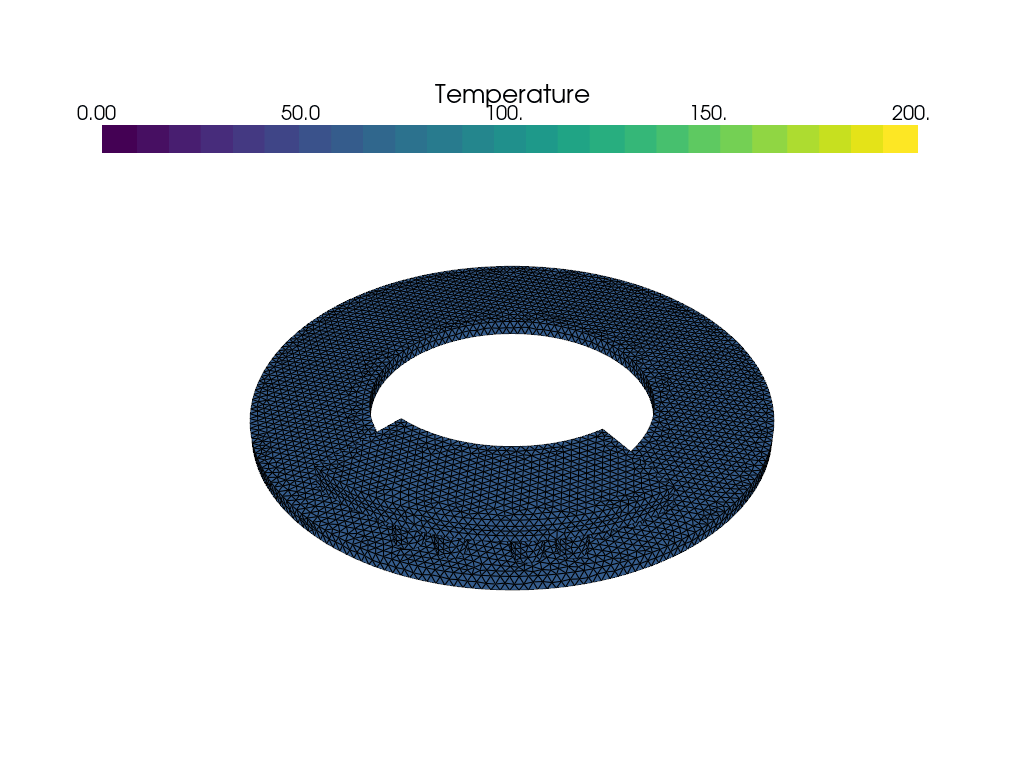

1: Start at: 2024-05-23 10:15:10
2: End at: 2024-05-23 10:26:06
3: Simulation time is 0 hours 11 minutes
4: First time step dt is 0.39741 s
5: Convection heat transfer coefficient is 7.75e-05 W/mm2 K
6: Radiation is 3.6e-13 W/mm2 K-4
7: Each rotation degree is 2200 per time step or 6.1 circle
8: The first rotation degree is 9599.3
9: The mid rotation degree is 9599.3
10: The last rotation degree is 9599.3
11: Total contact area of 18 rubbing element is 199.9 cm2
12: The mesh element size is between 3-10 mm
13: Total elements number is 43604

Move files successfully


In [8]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
              min = elapsed_time1 / 60
              hours = min / 60
              file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
              file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Project/Disc_thermal/Forward_Euler/"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results/Forward_Euler/"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
print("Move files successfully")

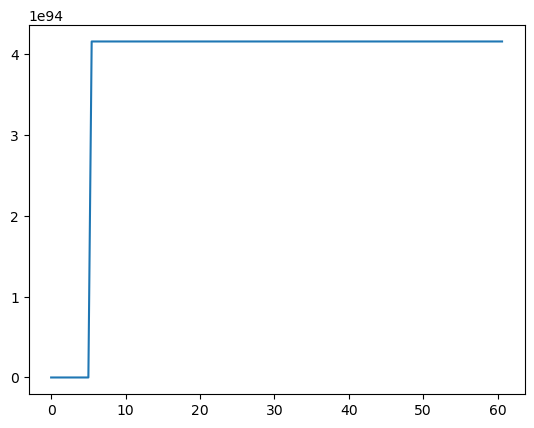

In [9]:
## get t and temperature T form T_array matrix
t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_max = []
for i in range(len(T)):
    T_max.append(max(T[i]))

plt.plot(t, T_max)

In [10]:
print(T_max)

[60, 60.47881224049485, 66.7579409524802, 72.83194292566317, 85.21157226449341, 280.9405630555275, 409.7298880722773, 2649.667009067527, 16909.377851228437, 46415.03126644394, 1672949.1298334398, 4812204585.244025, 5.9793091122933196e+26, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.153934681831175e+94, 4.

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]


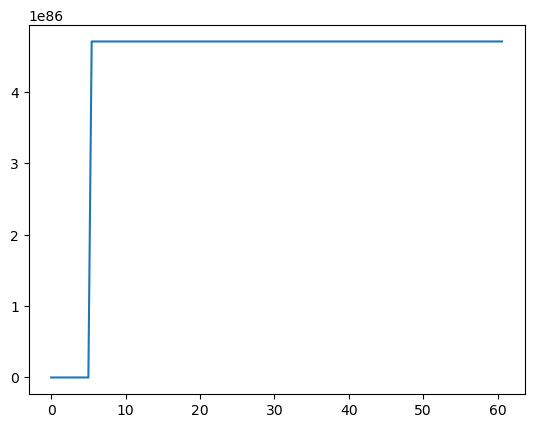

In [11]:
from brake_disc_functions import *

lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [12]:
lables = find_3_coord(mesh_filename1)
# T_3_labels = 3157, 7018, 2141
# for i in range(len(T)):
#   print( T[i][T_3_labels[1]] )

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]
